In [1]:
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def load_results(file_path):
    """Load results from JSON file."""
    with open(file_path, 'r') as f:
        return json.load(f)

In [3]:
def calculate_accuracy(predictions, ground_truths):
    """Calculate accuracy between predictions and ground truths."""
    # Convert Series to lists to avoid pandas Series ambiguity
    if hasattr(predictions, 'tolist'):
        predictions = predictions.tolist()
    if hasattr(ground_truths, 'tolist'):
        ground_truths = ground_truths.tolist()
    
    # Calculate accuracy
    correct = sum(1 for p, g in zip(predictions, ground_truths) if str(p) == str(g))
    return correct / len(predictions) if predictions else 0

In [4]:
def calculate_error_metrics(predictions, ground_truths, category=None):
    """
    Calculate MAE, MSE, and RMSE between predictions and ground truths.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        category: Optional category name for the analysis
        
    Returns:
        Dictionary containing MAE, MSE, and RMSE
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate differences
    differences = [abs(p - t) for p, t in zip(preds, truths)]
    
    # Calculate metrics
    mae = sum(differences) / len(differences)
    mse = sum(d * d for d in differences) / len(differences)
    rmse = mse ** 0.5
    
    result = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'sample_size': len(differences)
    }
    
    if category:
        result['category'] = category
        
    return result

In [5]:
def calculate_off_by_n_accuracy(predictions, ground_truths, n=1):
    """
    Calculate accuracy within n counts of the ground truth.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        n: Maximum allowed difference (default=1)
        
    Returns:
        Dictionary containing accuracy for each tolerance level up to n
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    results = {}
    # Cumulative accuracies
    for tolerance in range(n + 1):
        correct = sum(1 for p, t in zip(preds, truths) if abs(p - t) <= tolerance)
        accuracy = correct / len(preds)
        results[f'off_by_{tolerance}'] = accuracy

    # Individual accuracies
    for tolerance in range(n + 1):
        if tolerance == 0:
            results[f'exactly_{tolerance}'] = results[f'off_by_{tolerance}']
        else:
            # Count only predictions that are exactly off by tolerance
            exact_count = sum(1 for p, t in zip(preds, truths) if abs(p - t) == tolerance)
            results[f'exactly_{tolerance}'] = exact_count / len(preds)

    return results

In [6]:
def analyze_error_distribution(predictions, ground_truths):
    """
    Analyze the distribution of counting errors.
    
    Args:
        predictions: List of predicted counts
        ground_truths: List of ground truth counts
        
    Returns:
        Dictionary containing error distribution statistics
    """
    # Convert to numeric values if they're strings
    preds = [int(str(p)) for p in predictions]
    truths = [int(str(g)) for g in ground_truths]
    
    # Calculate errors
    errors = [p - t for p, t in zip(preds, truths)]
    
    # Calculate statistics
    mean_error = sum(errors) / len(errors)
    median_error = sorted(errors)[len(errors) // 2]
    
    # Count over/under predictions
    over_count = sum(1 for e in errors if e > 0)
    under_count = sum(1 for e in errors if e < 0)
    exact_count = sum(1 for e in errors if e == 0)
    
    return {
        'mean_error': mean_error,
        'median_error': median_error,
        'over_count': over_count,
        'under_count': under_count,
        'exact_count': exact_count,
        'error_distribution': errors
    }

In [7]:
def calculate_random_baseline(min_count=0, max_count=10, n=2):
    """
    Calculate random baseline probabilities for off-by-n accuracy.
    
    Args:
        min_count: Minimum possible count (default=0)
        max_count: Maximum possible count (default=10)
        n: Maximum allowed difference for off-by-n (default=2)
        
    Returns:
        Dictionary containing baseline probabilities for each tolerance level
    """
    total_possible_counts = max_count - min_count + 1
    baseline_probs = {}
    
    # Calculate for each tolerance level
    for tolerance in range(n + 1):
        # For each possible count, calculate how many other counts would be considered correct
        correct_counts = 0
        for true_count in range(min_count, max_count + 1):
            # Count how many predictions would be considered correct for this true count
            for pred_count in range(min_count, max_count + 1):
                if abs(pred_count - true_count) <= tolerance:
                    correct_counts += 1
        
        # Calculate probability
        # For each true count, we have total_possible_counts possible predictions
        total_possible_predictions = total_possible_counts * total_possible_counts
        probability = correct_counts / total_possible_predictions
        
        baseline_probs[f'off_by_{tolerance}'] = probability
        
        # Calculate individual probabilities
        for tolerance in range(n + 1):
            if tolerance == 0:
                baseline_probs[f'exactly_{tolerance}'] = baseline_probs[f'off_by_{tolerance}']
            else:
                # Count only predictions that are exactly off by tolerance
                exact_counts = 0
                for true_count in range(min_count, max_count + 1):
                    for pred_count in range(min_count, max_count + 1):
                        if abs(pred_count - true_count) == tolerance:
                            exact_counts += 1
                
                baseline_probs[f'exactly_{tolerance}'] = exact_counts / (total_possible_counts * total_possible_counts)
    
    return baseline_probs

In [8]:
def analyze_results(results_file, model_name):
    """Analyze results across different dimensions with additional metrics."""
    results = load_results(results_file)
    
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # 1. Overall Accuracy
    overall_accuracy = calculate_accuracy(df['model_answer'], df['ground_truth'])
    print(f"\n{model_name} Overall Accuracy: {overall_accuracy:.2%}")
    
    # 2. Overall Error Metrics
    overall_error_metrics = calculate_error_metrics(df['model_answer'], df['ground_truth'], 'Overall')
    print("\nOverall Error Metrics:")
    for metric, value in overall_error_metrics.items():
        if metric != 'category' and metric != 'sample_size':
            print(f"{metric}: {value:.2f}")
    
    # 3. Off-by-N Accuracy (Overall)
    off_by_n = calculate_off_by_n_accuracy(df['model_answer'], df['ground_truth'], n=2)
    print("\nOverall Off-by-N Accuracy:")
    for n, acc in off_by_n.items():
        print(f"{n}: {acc:.2%}")
    
    # 4. Error Distribution (Overall)
    error_dist = analyze_error_distribution(df['model_answer'], df['ground_truth'])
    print("\nOverall Error Distribution:")
    print(f"Mean Error: {error_dist['mean_error']:.2f}")
    print(f"Median Error: {error_dist['median_error']:.2f}")
    print(f"Over-counts: {error_dist['over_count']}")
    print(f"Under-counts: {error_dist['under_count']}")
    print(f"Exact counts: {error_dist['exact_count']}")
    
    # 5. Question-type Analysis
    df['question_type'] = df.apply(lambda x: int(x['question_id'].replace('Q', '')), axis=1)
    df['question_category'] = df['question_type'].map({
        1: 'Direct Recognition',
        2: 'Property Inference',
        3: 'Counterfactual'
    })

    question_accuracies = df.groupby('question_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Question Type:")
    for q_type, acc in question_accuracies.items():
        print(f"{q_type}: {acc:.2%}")
    
    # 6. Image Type Analysis
    image_type_accuracies = df.groupby('image_type').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Image Type:")
    for img_type, acc in image_type_accuracies.items():
        print(f"{img_type}: {acc:.2%}")

    # 7. Property Category Analysis
    property_accuracies = df.groupby('property_category').apply(
        lambda x: calculate_accuracy(x['model_answer'], x['ground_truth'])
    )
    print("\nAccuracy by Property Category:")
    for prop, acc in property_accuracies.items():
        print(f"{prop}: {acc:.2%}")


    # Calculate error metrics for each question category
    question_error_metrics = {}
    for q_type in df['question_category'].unique():
        q_df = df[df['question_category'] == q_type]
        question_error_metrics[q_type] = calculate_error_metrics(
            q_df['model_answer'], 
            q_df['ground_truth'],
            q_type
        )
    
    print("\nError Metrics by Question Type:")
    for q_type, metrics in question_error_metrics.items():
        print(f"\n{q_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    # Similar analysis for image types and property categories
    image_error_metrics = {}
    for i_type in df['image_type'].unique():
        i_df = df[df['image_type'] == i_type]
        image_error_metrics[i_type] = calculate_error_metrics(
            i_df['model_answer'],
            i_df['ground_truth'],
            i_type
        )
    
    print("\nError Metrics by Image Type:")
    for i_type, metrics in image_error_metrics.items():
        print(f"\n{i_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")


    property_error_metrics = {}
    for p_type in df['property_category'].unique():
        p_df = df[df['property_category'] == p_type]
        property_error_metrics[p_type] = calculate_error_metrics(
            p_df['model_answer'],
            p_df['ground_truth'],
            p_type
        )
    
    print("\nError Metrics by Property caterogry:")
    for p_type, metrics in property_error_metrics.items():
        print(f"\n{p_type}:")
        for metric, value in metrics.items():
            if metric != 'category' and metric != 'sample_size':
                print(f"{metric}: {value:.2f}")
    
    return {
        'overall': overall_accuracy,
        'overall_error_metrics': overall_error_metrics,
        'question_error_metrics': question_error_metrics,
        'off_by_n': off_by_n,
        'error_distribution': error_dist,
        'question_type': question_accuracies,
        'image_type': image_type_accuracies,
        'property': property_accuracies,
        'df': df
    }

In [9]:
# def plot_results(analysis_results, model_name):
#     """Create visualizations for the results."""
#     # Set style
#     plt.style.use('seaborn')
    
#     # Create figure with subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
#     # 1. Question Type Accuracy Plot
#     question_acc = analysis_results['question_type']
#     question_acc.plot(kind='bar', ax=ax1)
#     ax1.set_title(f'{model_name}: Accuracy by Question Type')
#     ax1.set_ylabel('Accuracy')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # 2. Image Type Accuracy Plot
#     image_acc = analysis_results['image_type']
#     image_acc.plot(kind='bar', ax=ax2)
#     ax2.set_title(f'{model_name}: Accuracy by Image Type')
#     ax2.set_ylabel('Accuracy')
#     ax2.tick_params(axis='x', rotation=45)
    
#     plt.tight_layout()
#     plt.savefig(f'{model_name}_analysis.png', bbox_inches='tight', dpi=300)
#     plt.close()

In [10]:
# def plot_results(analysis_results, model_name):
#     """Create visualizations for the results."""
#     # Import necessary libraries (add these if not already imported)
#     import matplotlib.pyplot as plt
#     import seaborn as sns
    
#     # Set style using a built-in matplotlib style instead
#     plt.style.use('ggplot')  # Alternative style that's built into matplotlib
#     # Or you can use seaborn directly to set the theme
#     sns.set_theme()  # This will apply the default seaborn styling
    
#     # Create figure with subplots
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
#     # 1. Question Type Accuracy Plot
#     question_acc = analysis_results['question_type']
#     sns.barplot(x=question_acc.index, y=question_acc.values, ax=ax1)
#     ax1.set_title(f'{model_name}: Accuracy by Question Type')
#     ax1.set_ylabel('Accuracy')
#     ax1.tick_params(axis='x', rotation=45)
    
#     # 2. Image Type Accuracy Plot
#     image_acc = analysis_results['image_type']
#     sns.barplot(x=image_acc.index, y=image_acc.values, ax=ax2)
#     ax2.set_title(f'{model_name}: Accuracy by Image Type')
#     ax2.set_ylabel('Accuracy')
#     ax2.tick_params(axis='x', rotation=45)
    
#     plt.tight_layout()
#     plt.savefig(f'{model_name}_analysis.png', bbox_inches='tight', dpi=300)
#     plt.close()

In [11]:
def plot_results(analysis_results, model_name):
    """Create visualizations for the results."""
    # Use a simple style that's guaranteed to work
    plt.style.use('default')
    
    # Set color scheme manually
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Question Type Accuracy Plot
    question_acc = analysis_results['question_type']
    bars1 = question_acc.plot(kind='bar', ax=ax1, color=colors)
    ax1.set_title(f'{model_name}: Accuracy by Question Type', pad=20)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on top of bars
    for i, v in enumerate(question_acc):
        ax1.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # 2. Image Type Accuracy Plot
    image_acc = analysis_results['image_type']
    bars2 = image_acc.plot(kind='bar', ax=ax2, color=colors)
    ax2.set_title(f'{model_name}: Accuracy by Image Type', pad=20)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)

    # Add value labels on top of bars
    for i, v in enumerate(image_acc):
        ax2.text(i, v + 0.01, f'{v:.1%}', ha='center', va='bottom')
    
    # Adjust layout
    plt.tight_layout()
    
    # Save figure
    plt.savefig(f'{model_name}_analysis.png', bbox_inches='tight', dpi=300)
    plt.close()

In [12]:
# def compare_models(model_results_dict):
#     """Compare results across different models."""
#     comparison_df = pd.DataFrame({
#         model: {
#             'Overall Accuracy': results['overall'],
#             'Direct Recognition': results['question_type']['Direct Recognition'],
#             'Property Inference': results['question_type']['Property Inference'],
#             'Counterfactual': results['question_type']['Counterfactual']
#         }
#         for model, results in model_results_dict.items()
#     }).T
    
#     # Format the DataFrame to display percentages with two decimal places
#     formatted_df = comparison_df.applymap(lambda x: f"{x * 100:.2f}%")

#     print("\nModel Comparison:")
#     print(formatted_df.to_string())
    
#     # Plot model comparison
#     plt.figure(figsize=(12, 6))
#     comparison_df.plot(kind='bar')
#     plt.title('Model Comparison Across Question Types')
#     plt.xlabel('Models')
#     plt.ylabel('Accuracy')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.savefig('model_comparison.png', bbox_inches='tight', dpi=300)
#     plt.close()

In [13]:
def compare_models_extended(model_results_dict):
    """Compare results across different models for question types, image types, and property categories."""
    # Use default style
    plt.style.use('default')
    
    # Create three DataFrames - one for each category type
    question_df = pd.DataFrame({
        model: {
            'Overall Accuracy': results['overall'],
            'Direct Recognition': results['question_type']['Direct Recognition'],
            'Property Inference': results['question_type']['Property Inference'],
            'Counterfactual': results['question_type']['Counterfactual']
        }
        for model, results in model_results_dict.items()
    }).T

    image_df = pd.DataFrame({
        model: {
            'REAL': results['image_type']['REAL'],
            'ANIMATED': results['image_type']['ANIMATED'],
            'AI_GENERATED': results['image_type']['AI_GENERATED']
        }
        for model, results in model_results_dict.items()
    }).T

    # Create property category DataFrame
    property_df = pd.DataFrame({
        model: {
            # 'functional/relational': results['property']['functional/relational'],
            'physical': results['property']['physical'],
            'taxonomic': results['property']['taxonomic'],
            'functional': results['property']['functional'],
            'relational': results['property']['relational'],
            # 'taxonomic/relational': results['property']['taxonomic/relational']
        }
        for model, results in model_results_dict.items()
    }).T
    
    # Format DataFrames to display percentages
    formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
    formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")

    # Print formatted results
    print("\nModel Comparison by Question Type:")
    print(formatted_question_df.to_string())
    print("\nModel Comparison by Image Type:")
    print(formatted_image_df.to_string())
    print("\nModel Comparison by Property Category:")
    print(formatted_property_df.to_string())
    
    # Create figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
    
    # Plot 1: Question Types
    question_df.plot(kind='bar', ax=ax1, width=0.8)
    ax1.set_title('Model Comparison Across Question Types', pad=20)
    ax1.set_xlabel('')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_xticklabels(ax1.get_xticklabels(), ha='right')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels for question types
    for i in range(len(question_df)):
        for j in range(len(question_df.columns)):
            value = question_df.iloc[i, j]
            ax1.text(i, value, f'{value:.1%}', 
                    ha='center', va='bottom')
    
    # Plot 2: Image Types
    image_df.plot(kind='bar', ax=ax2, width=0.8)
    ax2.set_title('Model Comparison Across Image Types', pad=20)
    ax2.set_xlabel('')
    ax2.set_ylabel('Accuracy')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_xticklabels(ax2.get_xticklabels(), ha='right')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels for image types
    for i in range(len(image_df)):
        for j in range(len(image_df.columns)):
            value = image_df.iloc[i, j]
            ax2.text(i, value, f'{value:.1%}', 
                    ha='center', va='bottom')

    # Plot 3: Property Categories
    property_df.plot(kind='bar', ax=ax3, width=0.8)
    ax3.set_title('Model Comparison Across Property Categories', pad=20)
    ax3.set_xlabel('Models')
    ax3.set_ylabel('Accuracy')
    ax3.tick_params(axis='x', rotation=45)
    ax3.set_xticklabels(ax3.get_xticklabels(), ha='right')
    ax3.grid(True, alpha=0.3)
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels for property categories
    for i in range(len(property_df)):
        for j in range(len(property_df.columns)):
            value = property_df.iloc[i, j]
            ax3.text(i, value, f'{value:.1%}', 
                    ha='center', va='bottom')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig('model_comparison_extended.png', bbox_inches='tight', dpi=300)
    plt.close()

    return question_df, image_df, property_df

In [14]:
# Analyze results for each model
model_results = {}

# List of result files to analyze
result_files = {
    # 'BLIP2-OPT-6.7B': 'blip2-opt6.7b_results.json',
    # 'BLIP2-OPT-2.7B': 'blip2-opt2.7b_results.json',
    # 'SmolVLM2-2.2B-Instruct_fp16': '/var/scratch/ave303/OP_bench/results/smolVLM2_results_1.json',
    # 'InternVL2.5-4B-MPO_fp16': '/var/scratch/ave303/OP_bench/results/InternVL2.5_results_1.json',
    'Qwen2.5-VL-7B-Instruct_fp16': '/var/scratch/ave303/OP_bench/Qwen2.5-VL_results.json',
    # 'Ristretto-3B_fp16': '/var/scratch/ave303/OP_bench/results/Ristretto_3b_results.json'
    'InternVL3-8B_fp16': '/var/scratch/ave303/OP_bench/InternVL3_results_8b.json',
    'InternVL2.5-8B-MPO_fp16': '/var/scratch/ave303/OP_bench/InternVL2.5_results_8bMPO.json'
    # Add other model result files here
    # 'FUYU-8B': 'fuyu_results.json',
}

for model_name, file_path in result_files.items():
    if Path(file_path).exists():
        print(f"\nAnalyzing {model_name}...")
        results = analyze_results(file_path, model_name)
        model_results[model_name] = results
        plot_results(results, model_name)

# Calculate random baseline
random_baseline = calculate_random_baseline()
print("\nRandom Baseline Probabilities:")
for n, prob in random_baseline.items():
    print(f"{n}: {prob:.2%}")

# Compare models if we have multiple results
if len(model_results) > 1:
    question_df, image_df, property_df = compare_models_extended(model_results)


Analyzing Qwen2.5-VL-7B-Instruct_fp16...

Qwen2.5-VL-7B-Instruct_fp16 Overall Accuracy: 22.00%

Overall Error Metrics:
MAE: 1.72
MSE: 5.47
RMSE: 2.34

Overall Off-by-N Accuracy:
off_by_0: 22.00%
off_by_1: 58.00%
off_by_2: 74.00%
exactly_0: 22.00%
exactly_1: 36.00%
exactly_2: 16.00%

Overall Error Distribution:
Mean Error: -1.39
Median Error: -1.00
Over-counts: 18
Under-counts: 99
Exact counts: 33

Accuracy by Question Type:
Counterfactual: 18.00%
Direct Recognition: 20.00%
Property Inference: 28.00%

Accuracy by Image Type:
AI_GENERATED: 23.33%
ANIMATED: 23.33%
REAL: 20.00%

Accuracy by Property Category:
functional: 26.23%
physical: 21.95%
relational: 12.50%
taxonomic: 18.75%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.08
MSE: 7.80
RMSE: 2.79

Property Inference:
MAE: 1.48
MSE: 4.16
RMSE: 2.04

Counterfactual:
MAE: 1.60
MSE: 4.44
RMSE: 2.11

Error Metrics by Image Type:

REAL:
MAE: 1.97
MSE: 6.80
RMSE: 2.61

ANIMATED:
MAE: 1.47
MSE: 4.00
RMSE: 2.00

AI_GENERATED:
MAE

/tmp/ipykernel_1469173/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_1469173/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_1469173/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing InternVL3-8B_fp16...

InternVL3-8B_fp16 Overall Accuracy: 22.67%

Overall Error Metrics:
MAE: 1.56
MSE: 4.57
RMSE: 2.14

Overall Off-by-N Accuracy:
off_by_0: 22.67%
off_by_1: 61.33%
off_by_2: 80.67%
exactly_0: 22.67%
exactly_1: 38.67%
exactly_2: 19.33%

Overall Error Distribution:
Mean Error: -0.96
Median Error: -1.00
Over-counts: 30
Under-counts: 86
Exact counts: 34

Accuracy by Question Type:
Counterfactual: 28.00%
Direct Recognition: 18.00%
Property Inference: 22.00%

Accuracy by Image Type:
AI_GENERATED: 26.67%
ANIMATED: 26.67%
REAL: 16.67%

Accuracy by Property Category:
functional: 19.67%
physical: 21.95%
relational: 37.50%
taxonomic: 21.88%

Error Metrics by Question Type:

Direct Recognition:
MAE: 1.82
MSE: 5.94
RMSE: 2.44

Property Inference:
MAE: 1.54
MSE: 4.46
RMSE: 2.11

Counterfactual:
MAE: 1.32
MSE: 3.32
RMSE: 1.82

Error Metrics by Image Type:

REAL:
MAE: 1.78
MSE: 5.45
RMSE: 2.33

ANIMATED:
MAE: 1.40
MSE: 3.93
RMSE: 1.98

AI_GENERATED:
MAE: 1.43
MSE: 4.10
RMS

/tmp/ipykernel_1469173/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_1469173/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_1469173/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Analyzing InternVL2.5-8B-MPO_fp16...

InternVL2.5-8B-MPO_fp16 Overall Accuracy: 19.33%

Overall Error Metrics:
MAE: 1.94
MSE: 6.70
RMSE: 2.59

Overall Off-by-N Accuracy:
off_by_0: 19.33%
off_by_1: 53.33%
off_by_2: 70.00%
exactly_0: 19.33%
exactly_1: 34.00%
exactly_2: 16.67%

Overall Error Distribution:
Mean Error: -1.43
Median Error: -1.00
Over-counts: 23
Under-counts: 98
Exact counts: 29

Accuracy by Question Type:
Counterfactual: 16.00%
Direct Recognition: 16.00%
Property Inference: 26.00%

Accuracy by Image Type:
AI_GENERATED: 36.67%
ANIMATED: 11.67%
REAL: 18.33%

Accuracy by Property Category:
functional: 22.95%
physical: 17.07%
relational: 18.75%
taxonomic: 15.62%

Error Metrics by Question Type:

Direct Recognition:
MAE: 2.38
MSE: 9.46
RMSE: 3.08

Property Inference:
MAE: 1.66
MSE: 5.30
RMSE: 2.30

Counterfactual:
MAE: 1.78
MSE: 5.34
RMSE: 2.31

Error Metrics by Image Type:

REAL:
MAE: 2.23
MSE: 8.40
RMSE: 2.90

ANIMATED:
MAE: 1.78
MSE: 5.38
RMSE: 2.32

AI_GENERATED:
MAE: 1.67
M

/tmp/ipykernel_1469173/2790841813.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  question_accuracies = df.groupby('question_category').apply(
/tmp/ipykernel_1469173/2790841813.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  image_type_accuracies = df.groupby('image_type').apply(
/tmp/ipykernel_1469173/2790841813.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. T


Random Baseline Probabilities:
off_by_0: 9.09%
exactly_0: 9.09%
exactly_1: 16.53%
exactly_2: 14.88%
off_by_1: 25.62%
off_by_2: 40.50%

Model Comparison by Question Type:
                            Overall Accuracy Direct Recognition Property Inference Counterfactual
Qwen2.5-VL-7B-Instruct_fp16           22.00%             20.00%             28.00%         18.00%
InternVL3-8B_fp16                     22.67%             18.00%             22.00%         28.00%
InternVL2.5-8B-MPO_fp16               19.33%             16.00%             26.00%         16.00%

Model Comparison by Image Type:
                               REAL ANIMATED AI_GENERATED
Qwen2.5-VL-7B-Instruct_fp16  20.00%   23.33%       23.33%
InternVL3-8B_fp16            16.67%   26.67%       26.67%
InternVL2.5-8B-MPO_fp16      18.33%   11.67%       36.67%

Model Comparison by Property Category:
                            physical taxonomic functional relational
Qwen2.5-VL-7B-Instruct_fp16   21.95%    18.75%     26.23%     1

/tmp/ipykernel_1469173/2224759949.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_question_df = question_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_1469173/2224759949.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_image_df = image_df.applymap(lambda x: f"{x * 100:.2f}%")
/tmp/ipykernel_1469173/2224759949.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_property_df = property_df.applymap(lambda x: f"{x * 100:.2f}%")


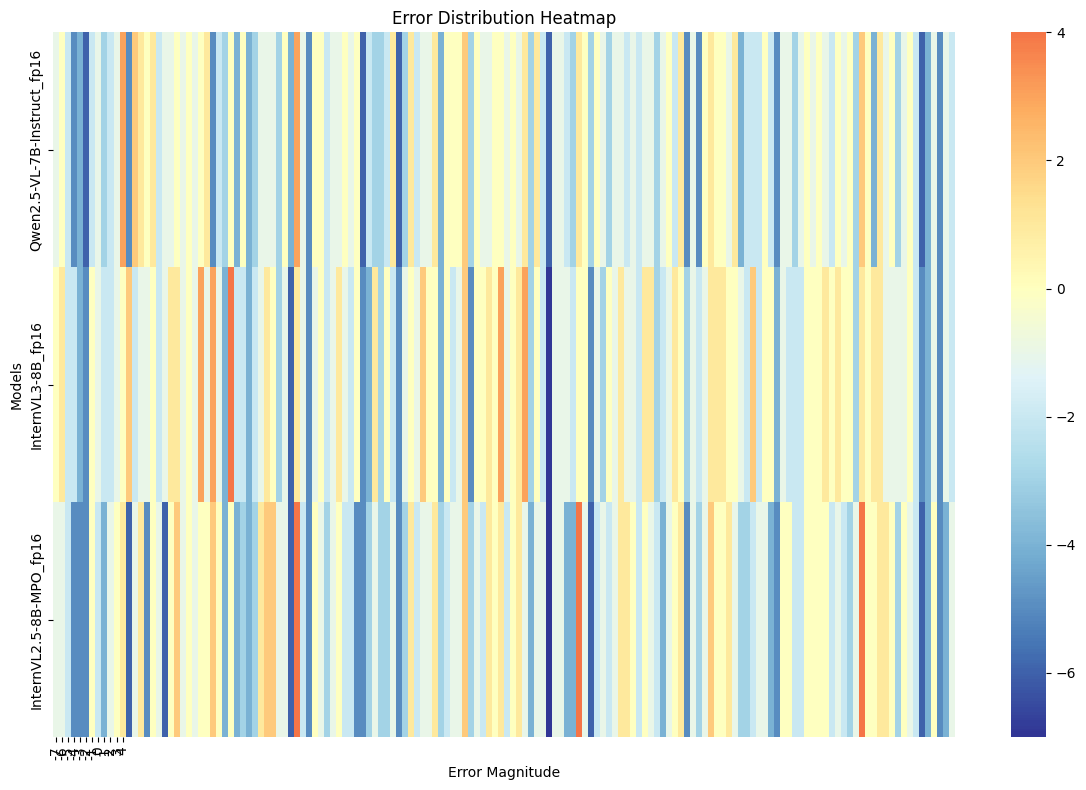

In [15]:
def plot_error_heatmap(model_results_dict):
    """Create a heatmap showing error distribution across categories."""
    plt.figure(figsize=(12, 8))
    error_data = []
    categories = []
    models = list(model_results_dict.keys())
    
    for model in models:
        errors = model_results_dict[model]['error_distribution']['error_distribution']
        error_data.append(errors)
        categories.append(model)
    
    sns.heatmap(error_data, cmap='RdYlBu_r', center=0, 
                xticklabels=range(min(errors), max(errors)+1),
                yticklabels=models)
    plt.title('Error Distribution Heatmap')
    plt.xlabel('Error Magnitude')
    plt.ylabel('Models')
    plt.tight_layout()

plot_error_heatmap(model_results)

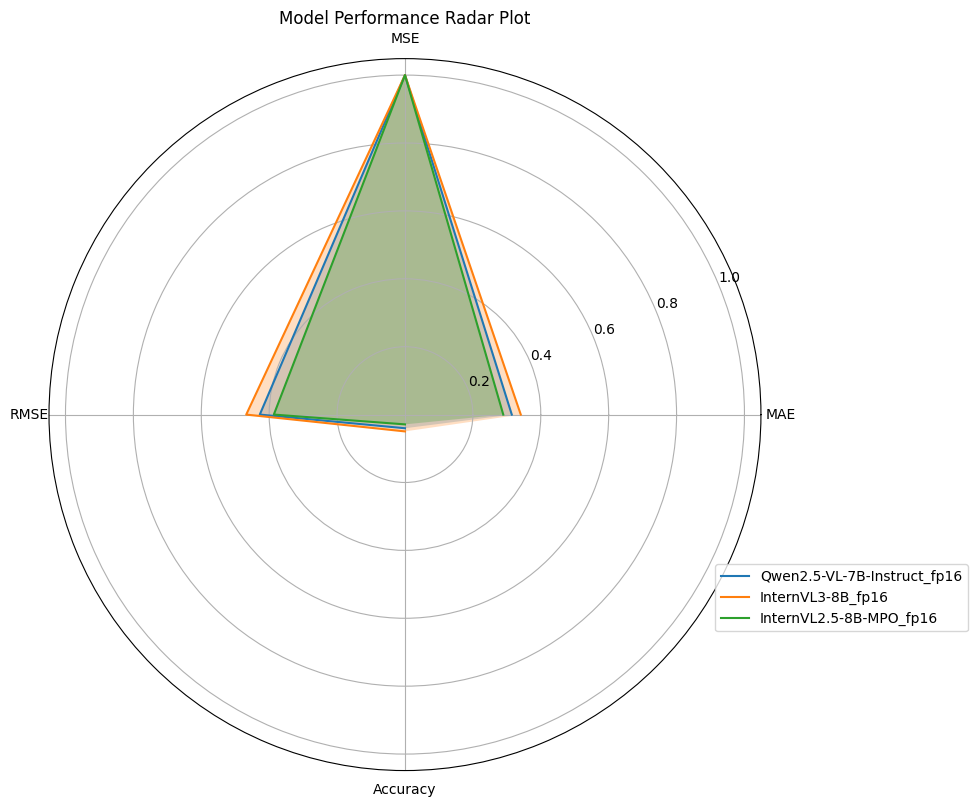

In [16]:
def plot_radar_metrics(model_results_dict):
    """Create a radar plot comparing multiple metrics across models."""
    metrics = ['MAE', 'MSE', 'RMSE', 'Accuracy']
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    for model, results in model_results_dict.items():
        values = [
            results['overall_error_metrics']['MAE'],
            results['overall_error_metrics']['MSE'],
            results['overall_error_metrics']['RMSE'],
            results['overall']
        ]
        # Normalize values for better visualization
        values = [v/max(values) for v in values]
        ax.plot(angles, values, label=model)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_xticks(angles)
    ax.set_xticklabels(metrics)
    ax.set_title('Model Performance Radar Plot')
    plt.legend(bbox_to_anchor=(1.3, 0.3))
    plt.tight_layout()

plot_radar_metrics(model_results)

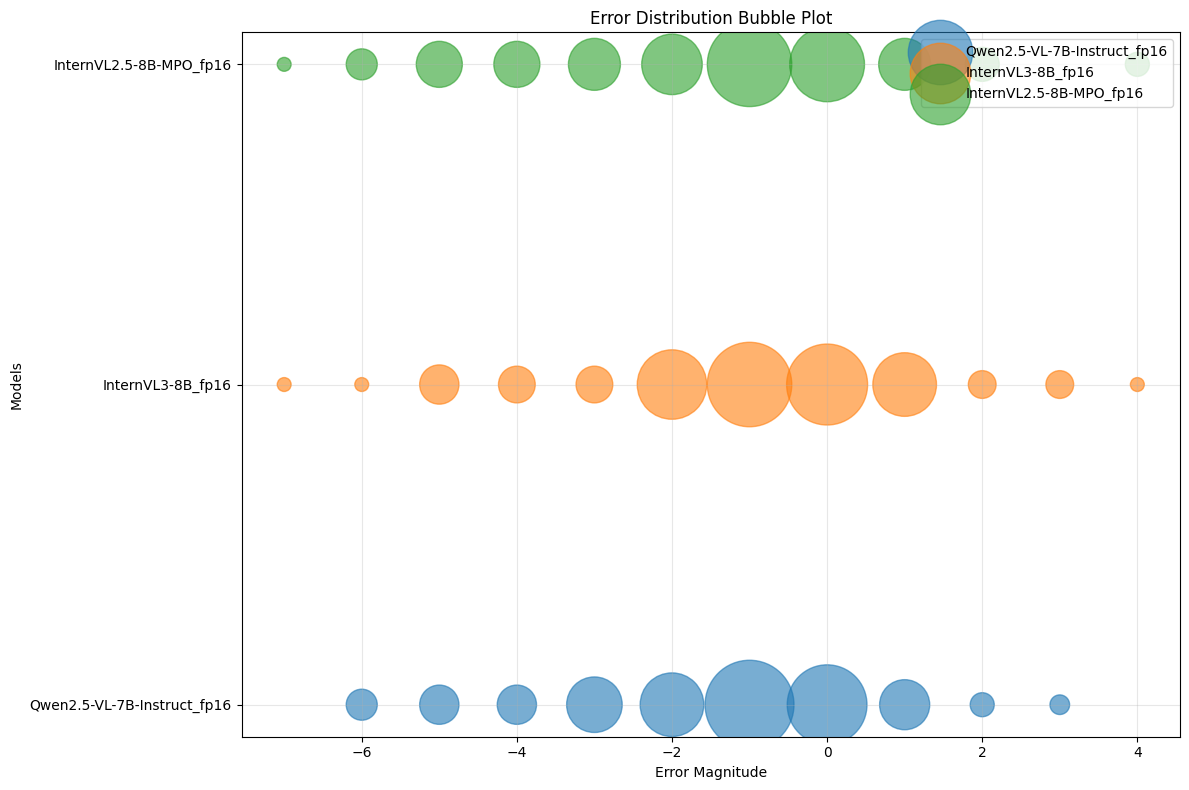

In [17]:
def plot_error_bubbles(model_results_dict):
    """Create a bubble plot showing error distribution."""
    plt.figure(figsize=(12, 8))
    
    for model, results in model_results_dict.items():
        errors = results['error_distribution']['error_distribution']
        error_counts = pd.Series(errors).value_counts()
        
        plt.scatter(error_counts.index, 
                   [model] * len(error_counts),
                   s=error_counts.values * 100,
                   alpha=0.6,
                   label=model)
    
    plt.title('Error Distribution Bubble Plot')
    plt.xlabel('Error Magnitude')
    plt.ylabel('Models')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

plot_error_bubbles(model_results)


Question Distribution by Property Category:
                   Count  Percentage
property_category                   
functional            61       40.67
physical              41       27.33
taxonomic             32       21.33
relational            16       10.67


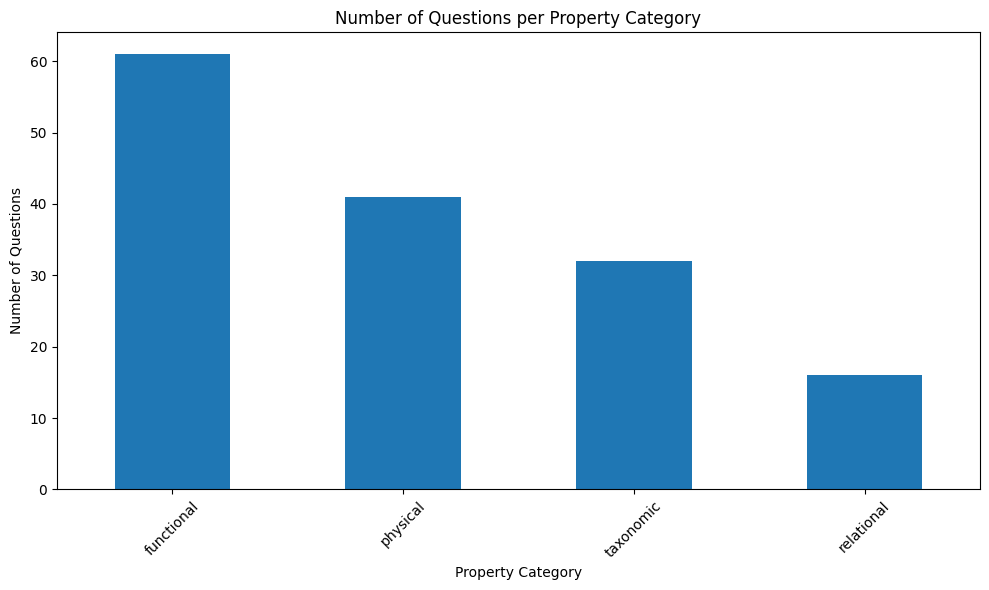

In [18]:
def analyze_question_distribution(results_file):
    """Analyze the distribution of questions across property categories."""
    results = load_results(results_file)
    df = pd.DataFrame(results)
    
    # Count questions per property category
    property_counts = df['property_category'].value_counts()
    
    # Calculate percentages
    property_percentages = (property_counts / len(df) * 100).round(2)
    
    # Create a summary DataFrame
    summary_df = pd.DataFrame({
        'Count': property_counts,
        'Percentage': property_percentages
    })
    
    print("\nQuestion Distribution by Property Category:")
    print(summary_df)
    
    # Visualize the distribution
    plt.figure(figsize=(10, 6))
    property_counts.plot(kind='bar')
    plt.title('Number of Questions per Property Category')
    plt.xlabel('Property Category')
    plt.ylabel('Number of Questions')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return summary_df

# Usage:
distribution = analyze_question_distribution('/var/scratch/ave303/OP_bench/InternVL3_results_8b.json')